In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('C:/Users/petera/Documents/Envirodual/paths')
sys.path.append('C:/Users/petera/Documents/Envirodual/values')
from pathlib import Path
from path_definition import all_cities, model
import sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math
import pickle
import matplotlib
import matplotlib.pyplot as plt

## Read data

In [2]:
audits_path = all_cities['root'] / model['audits_cleaned_for_model']
audits = pd.read_csv(
    audits_path,
    index_col = 'STA_SID',
)
print(f'\n Data set size AUDITS: {audits.shape}')


 Data set size AUDITS: (2826, 214)


In [3]:
kranj_path = all_cities['root'] / model['gas_kranj']
gas_kranj = pd.read_csv(
    kranj_path,
    index_col = 'STA_SID',
)
print(f'\n Data set size GAS_KRANJ: {gas_kranj.shape}')


 Data set size GAS_KRANJ: (1957, 214)


In [4]:
ljubljana_path = all_cities['root'] / model['gas_ljubljana']
gas_ljubljana = pd.read_csv(
    ljubljana_path,
    index_col = 'STA_SID',
)
print(f'\n Data set size GAS_LJUBLJANA: {gas_ljubljana.shape}')


 Data set size GAS_LJUBLJANA: (15657, 214)


Add data year as variable

In [5]:
gas_ljubljana['YEAR_MEASURED'] = 2017
gas_kranj['YEAR_MEASURED'] = 2019

42

In [6]:
# rename gas column to match audits primary energy columns
gas_ljubljana.rename(columns={'ZP': 'PRIMARY'}, inplace=True)
gas_kranj.rename(columns={'ZP': 'PRIMARY'}, inplace=True)

## Separate validation set for just Kranj

In [7]:
def split_vals(a,n): 
    return a.iloc[:n].copy(), a.iloc[n:].copy()

n_valid = 500; 
n_kranj = len(gas_kranj) - n_valid

gas_kranj, gas_kranj_valid = split_vals(gas_kranj, n_kranj)

## Concatenate datasets

In [8]:
#audits = pd.DataFrame()
#gas_kranj = pd.DataFrame()
#gas_ljubljana = pd.DataFrame()
df_raw = pd.concat([audits, gas_kranj, gas_ljubljana])
#df_raw = gas_kranj
#df_raw = gas_ljubljana
#df_raw = audits
print(f'\n Data set size: {df_raw.shape}')


 Data set size: (19940, 215)


In [9]:
# fill column TIP_STAVBE_3 - not present in audits prior to above cell since no audited building had this property
df_raw.fillna(0, inplace=True)

In [10]:
# drop buildings with 0 m2 surface area
df = df_raw.copy()
df = df[df['UPORABNA_POVRSINA'] > 5]
df = df[df['NETO_TLORIS'] > 5]
print(f'\n Data set size: {df.shape}')


 Data set size: (19861, 215)


## Independent variable

In [11]:
from values import heated_area_cols

In [12]:
independent_var = 'heat_m2'
surface_variable = 'HEATED_AREA' # UPORABNA_POVRSINA HEATED_AREA
primary_energy_column = 'PRIMARY'

In [13]:
# create variable heat per m2
conversion_efficiency = 0.95
df[independent_var] = df[primary_energy_column] * conversion_efficiency  / df[surface_variable] #

In [14]:
# cutoff 
lower = 10
upper = 1300
df = df[df[independent_var] < upper]
df = df[df[independent_var] > lower]
print(f'\n Data set size: {df.shape}')


 Data set size: (18670, 216)


LOG-TRANSFORM OF TARGET VARIABLE
We use the numpy fuction log1p which  applies log(1+x) to all elements of the column

In [15]:
independent_var = 'log1p_heat_m2'
df['log1p_heat_m2'] = np.log1p(df['heat_m2'])
df = df.drop(columns='heat_m2')

In [16]:
# drop irrelevant variables
df.drop(columns=primary_energy_column, inplace=True)
df.drop(columns='OB_MID', inplace=True)

Normalize surface area variables. We divide the area use variables by the total useful area "sufrace_variable" - UPORABNA_POVRSINA

In [17]:
from values import area_use_columns
for i in area_use_columns:
    df[i] =df[i]/df[surface_variable]

## Train, validation & test sets

In [18]:
# Split set into train and test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.0, random_state=42)

df_trn = train_set.drop(independent_var, axis=1)
y_trn = train_set[independent_var].copy()

X_test = test_set.drop(independent_var, axis=1)
y_test = test_set[independent_var].copy()

In [19]:
# make validation set
def split_vals(a,n): return a.iloc[:n].copy(), a.iloc[n:].copy()

n_valid = 800
n_trn = len(df_trn)-n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(train_set, n_trn)

X_train.shape, X_valid.shape, X_test.shape, X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]

((17870, 213), (800, 213), (0, 213), 18670)

In [20]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = ['RMSE train:', round(rmse(m.predict(X_train), y_train), 5), 
           'RMSE valid:', round(rmse(m.predict(X_valid), y_valid), 5),
           'R2 train:', round(m.score(X_train, y_train), 5), 
           'R2 valid:',round(m.score(X_valid, y_valid), 5)]
    if hasattr(m, 'oob_score_'): res.append(['R2 oob_score_', round(m.oob_score_, 5)])
    print(res)

## Fit model

In [21]:
m1 = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, 
                      max_depth=3, min_child_weight=1.7817, n_estimators=800,
                      reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, 
                      silent=1, random_state=7, nthread=-1)
%time m1.fit(X_train, y_train)
print_score(m1)

Wall time: 32.6 s
['RMSE train:', 0.558, 'RMSE valid:', 0.58739, 'R2 train:', 0.31606, 'R2 valid:', 0.22541]


In [22]:
m2 = RandomForestRegressor(n_estimators=800, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m2.fit(X_train, y_train)
print_score(m2)

Wall time: 54.4 s
['RMSE train:', 0.35682, 'RMSE valid:', 0.60517, 'R2 train:', 0.72032, 'R2 valid:', 0.1778, ['R2 oob_score_', 0.23073]]


In [23]:
m3 = RandomForestRegressor(n_estimators=1500, min_samples_leaf=3, max_features=0.21, n_jobs=-1, oob_score=True)
%time m3.fit(X_train, y_train)
print_score(m3)

Wall time: 1min 2s
['RMSE train:', 0.39891, 'RMSE valid:', 0.59818, 'R2 train:', 0.65046, 'R2 valid:', 0.19668, ['R2 oob_score_', 0.23413]]


## Feature importance

In [24]:
fi = pd.DataFrame({'cols': X_valid.columns, 'imp': m1.feature_importances_}).sort_values('imp', ascending=False)

In [25]:
#fi[:15]

In [26]:
#fi.plot('cols', 'imp', figsize=(13,5), legend=False)

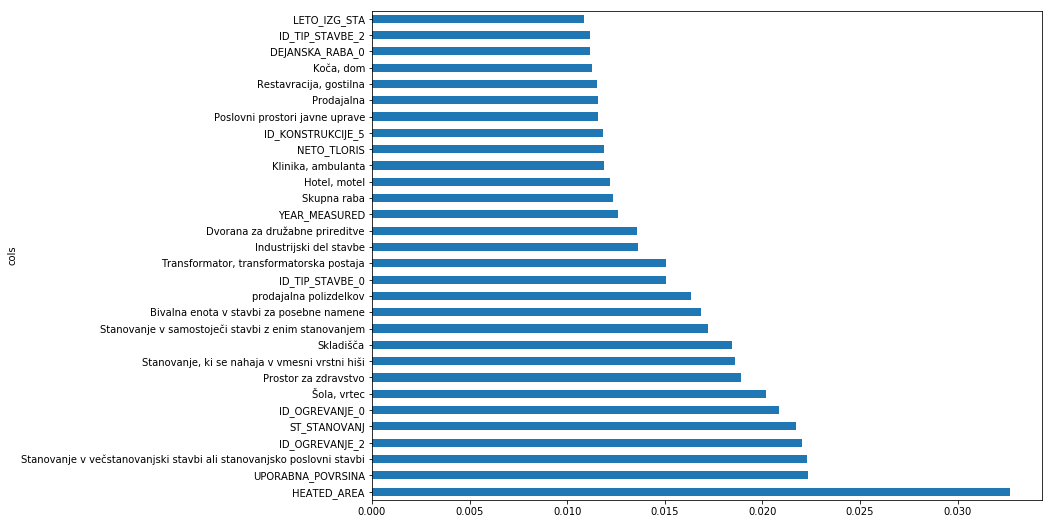

In [27]:
fi.set_index('cols')[:30].plot.barh(figsize=(12,9), legend=False);

## Removing insignificant features

In [28]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

93

In [29]:
df_keep = df_trn[to_keep].copy()
keep_cols = df_keep.columns
X_train, X_valid = split_vals(df_keep, n_trn)
X_test = X_test[keep_cols]

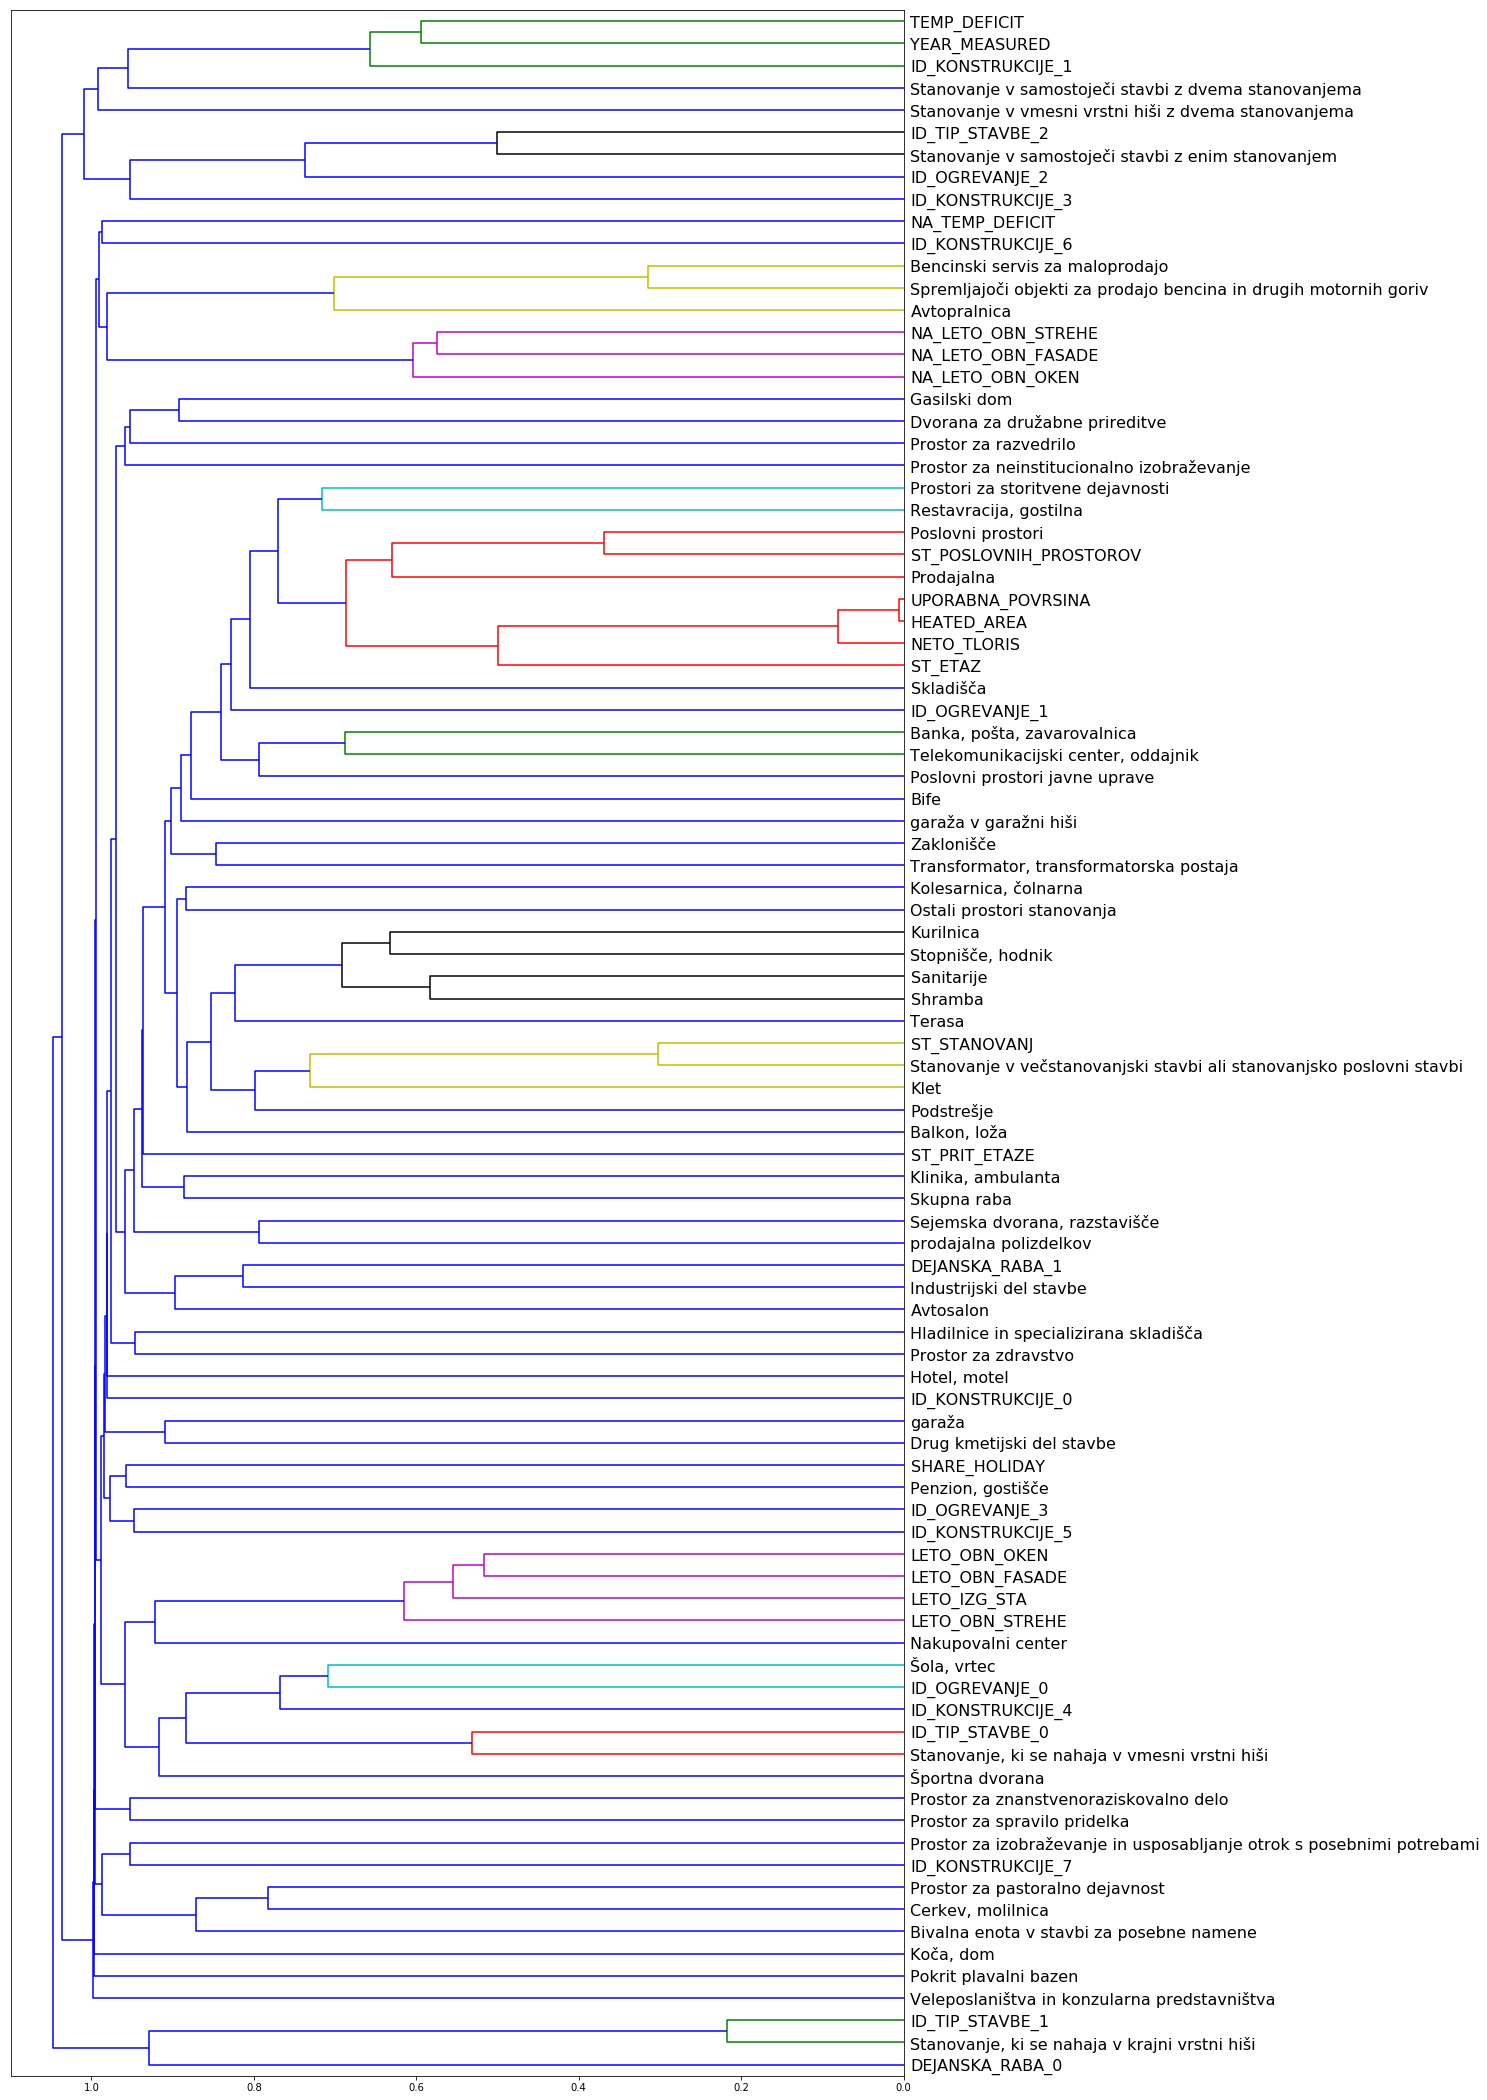

In [30]:
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 1 + int(len(to_keep)/2.5)))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Compare R2 score with and without given variables

In [31]:
def get_oob(df): # out of band score
    m = RandomForestRegressor(n_estimators=800, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [32]:
#m = RandomForestRegressor(n_estimators=800, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
#%time m.fit(X_train, y_train)
#print_score(m)

In [33]:
# Get R2 without individual features
#for c in ('HEATED_AREA', 'NETO_TLORIS', 'UPORABNA_POVRSINA', 'TEMP_DEFICIT', 'YEAR_MEASURED'):
#    print(c, round(get_oob(df_keep.drop(c, axis=1)), 5))

## Check model on test set

In [34]:
m = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, 
    n_estimators=800, reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state=7, nthread=-1)
#m = RandomForestRegressor(n_estimators=800, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 20.3 s
['RMSE train:', 0.55792, 'RMSE valid:', 0.58789, 'R2 train:', 0.31626, 'R2 valid:', 0.22408]


In [35]:
# save model
model_designation = '_13_04.pkl'
model_path = all_cities['root'] / ('prediction_models/model' + model_designation)
#with open(model_path, 'wb') as f: pickle.dump(m, f)

columns_path = all_cities['root'] / ('prediction_models/columns_model' + model_designation)
#with open(columns_path, 'wb') as f: pickle.dump(to_keep, f)

In [36]:
y_train_predicted = m.predict(X_train)
actual = round(np.expm1(y_train).mean(), 1)
predicted = round(np.expm1(y_train_predicted).mean(), 1)
print(f'Mean actual:    {actual} kWh')
print(f'Mean predicted: {predicted} kWh')

Mean actual:    151.1 kWh
Mean predicted: 128.1999969482422 kWh


In [37]:
# Test set predictions
def error_distribution(m, X, y):
    y_pred_expm1 = np.expm1(m.predict(X))
    y_exp1m = np.expm1(y)

    absolute_error = abs(y_pred_expm1 - y_exp1m)
    relative_error = absolute_error / y_exp1m * 100 
    
    df = pd.DataFrame({'Absolute error': absolute_error, 'Relative error %': (relative_error)})
    print(df.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .95]).round(2))

In [38]:
error_distribution(m, X_valid, y_valid.values)

       Absolute error  Relative error %
count          800.00            800.00
mean            60.29             55.42
std             86.00            114.47
min              0.10              0.11
10%              6.15              5.10
20%             12.01             10.93
30%             20.48             16.26
40%             27.19             22.43
50%             36.20             28.79
60%             47.49             35.95
70%             61.72             44.06
80%             79.90             58.44
90%            121.96            100.07
95%            192.53            183.54
max           1036.33           1156.94


In [39]:
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

In [40]:
predicted_train = np.expm1(m.predict(X_train))
actual_train = np.expm1(y_train.values)

E_train = predicted_train - actual_train
AE_train = abs(E_train)
RE_train = E_train / actual_train * 100

predicted_valid = np.expm1(m.predict(X_valid))
actual_valid = np.expm1(y_valid.values)

E_valid = predicted_valid - actual_valid
AE_valid = abs(E_valid)
RE_valid = E_valid / actual_valid * 100

(0, 0.02)

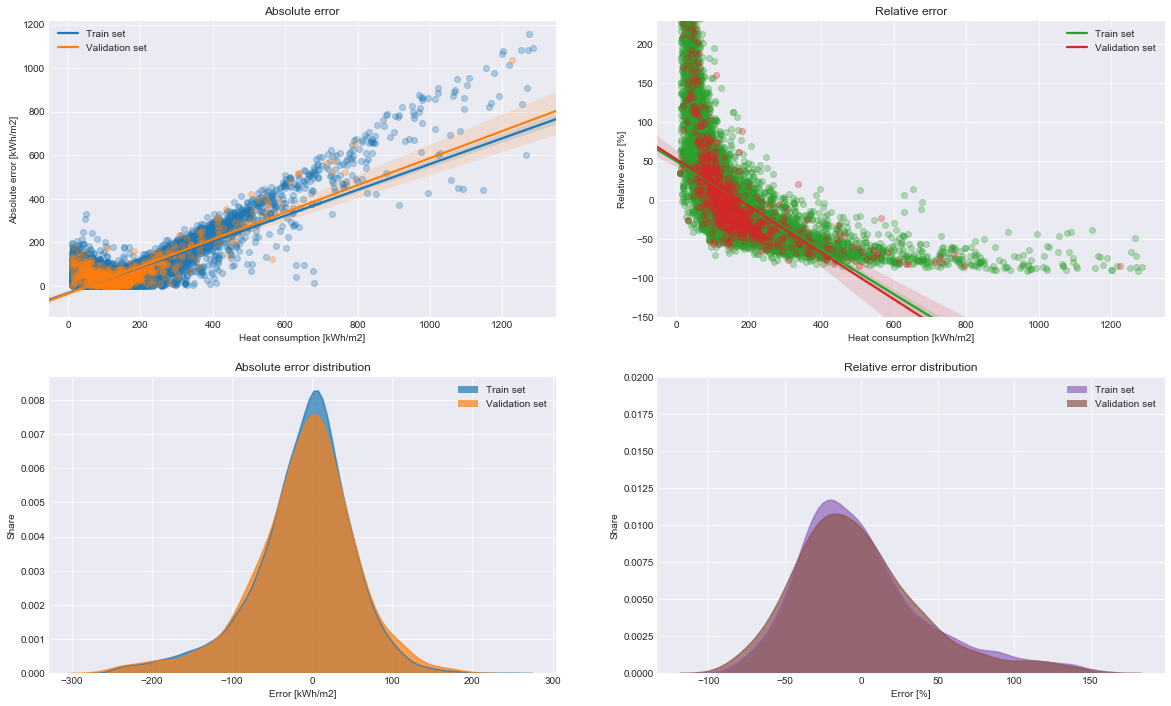

In [41]:
# VISUALISATION RESULTS
_, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

ax1.set_title('Absolute error')
sns.regplot(x=actual_train, y=AE_train, scatter_kws={'alpha':0.3}, ax=ax1)
sns.regplot(x=actual_valid, y=AE_valid, scatter_kws={'alpha':0.3}, ax=ax1)
ax1.set_xlabel('Heat consumption [kWh/m2]')
ax1.set_ylabel('Absolute error [kWh/m2]')
ax1.legend(['Train set', 'Validation set'])

ax2.set_title('Relative error')
subset_x = actual_train[abs(RE_train) < 250]
subset_y = RE_train[abs(RE_train) < 250]
sns.regplot(x=subset_x, y=subset_y, lowess=False, scatter_kws={'alpha':0.3}, ax=ax2)
subset_x = actual_valid[abs(RE_valid) < 250]
subset_y = RE_valid[abs(RE_valid) < 250]
sns.regplot(x=subset_x, y=subset_y, lowess=False, scatter_kws={'alpha':0.3}, ax=ax2)
ax2.set_xlabel('Heat consumption [kWh/m2]')
ax2.set_ylabel('Relative error [%]')
ax2.legend(['Train set', 'Validation set'])
ax2.set_ylim([-150, 230])

ax3.set_title('Absolute error distribution')
sns.kdeplot(E_train[abs(E_train) < 250], shade=True, alpha=0.7, ax=ax3)
sns.kdeplot(E_valid[abs(E_valid) < 250], shade=True, alpha=0.7, ax=ax3)
ax3.set_xlabel('Error [kWh/m2]')
ax3.set_ylabel('Share')
ax3.legend(['Train set', 'Validation set'])

ax4.set_title('Relative error distribution')
sns.kdeplot(RE_train[RE_train < 150], shade=True, alpha=0.7, ax=ax4)
sns.kdeplot(RE_valid[RE_valid < 150], shade=True, alpha=0.7, ax=ax4)
ax4.set_xlabel('Error [%]')
ax4.set_ylabel('Share')
ax4.legend(['Train set', 'Validation set'])
ax4.set_ylim([0, 0.02])

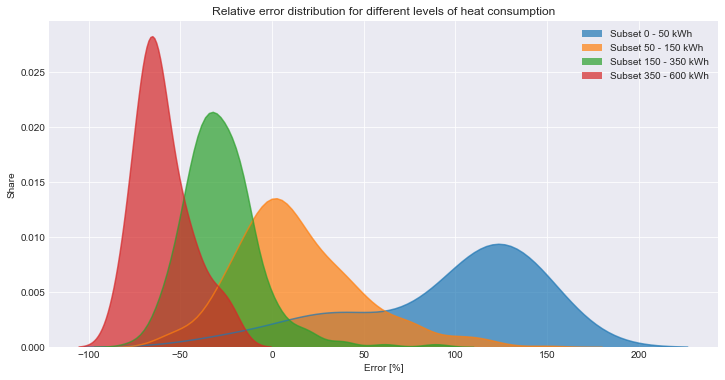

In [42]:
 # Figure: error for different levels of heat consumption
_, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Relative error distribution for different levels of heat consumption')
ax.set_xlabel('Error [%]')
ax.set_ylabel('Share')
lower_bound = 0
legend = []

for upper_bound in [50, 150, 350, 600]:#, 1400]:
    subset = RE_valid[(lower_bound <= actual_valid) & (actual_valid < upper_bound)]
    sns.kdeplot(subset[abs(subset) < 150], shade=True, alpha=0.7, ax=ax)
    legend.append('Subset ' + str(lower_bound) + ' - ' + str(upper_bound) + ' kWh')
    lower_bound = upper_bound
ax.legend(legend)

## Test model on KRANJ

In [43]:
df = gas_kranj_valid

In [44]:
# add all fuel consumption (converted to heat) + all forms of delivered heat
df['heat_m2'] = df[primary_energy_column] * conversion_efficiency  / df[surface_variable] #

In [45]:
# cutoff 
lower = 10
upper = 1350
df = df[df['heat_m2'] < upper]
df = df[df['heat_m2'] > lower]
print(f'\n Data set size: {df.shape}')


 Data set size: (475, 216)


In [46]:
independent_var = 'log1p_heat_m2'
df[independent_var] = np.log1p(df['heat_m2'])
#df = df.drop(columns=independent_var)

# drop irrelevant variables
df.drop(columns=primary_energy_column, inplace=True)
df.drop(columns='OB_MID', inplace=True)

from values import area_use_columns
for i in area_use_columns:
    df[i] =df[i]/df[surface_variable]

In [47]:
X_kranj = df.drop(independent_var, axis=1)
X_kranj = X_kranj[to_keep]
y_kranj = df[independent_var].copy()

In [48]:
error_distribution(m, X_kranj, y_kranj.values)

       Absolute error  Relative error %
count          475.00            475.00
mean            51.09             55.51
std             77.30             77.45
min              0.00              0.00
10%              5.31              5.88
20%             12.62             12.38
30%             19.60             19.84
40%             26.11             25.99
50%             33.22             32.49
60%             42.81             39.30
70%             53.77             49.58
80%             66.96             68.83
90%             97.93            113.96
95%            129.11            240.78
max            801.78            542.77


In [49]:
gas_ljubljana.NA_ID_KONSTRUKCIJE.sum()

42